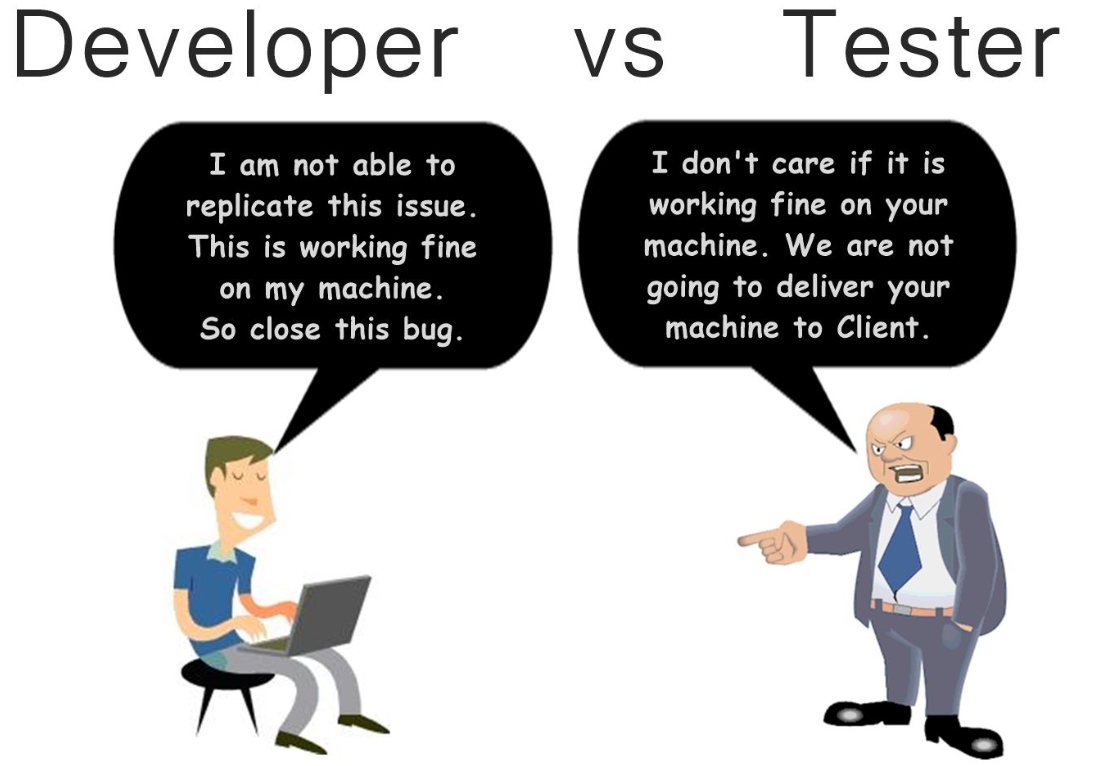

# Agents with Self Reflection

In [31]:
!git clone https://github.com/genaiconference/AgenticAI_GenAIHack.git

fatal: destination path 'AgenticAI_GenAIHack' already exists and is not an empty directory.


In [ ]:
!pip install -r /content/AgenticAI_GenAIHack/requirements_agenti_ai.txt

In [33]:
import warnings
warnings.filterwarnings("ignore")

import functools, operator, requests, os, json
from bs4 import BeautifulSoup
from langchain.agents import AgentExecutor, create_openai_tools_agent
from langchain_core.messages import BaseMessage, HumanMessage
from langchain.output_parsers.openai_functions import JsonOutputFunctionsParser
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langgraph.graph import StateGraph, END
from langchain.tools import tool
from typing import Annotated, Any, Dict, List, Optional, Sequence, TypedDict
from IPython.display import Markdown, JSON

from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma
from langchain_openai import OpenAIEmbeddings
from langchain.tools.retriever import create_retriever_tool
from langchain_experimental.tools import PythonREPLTool
from langchain.agents import Tool

#### Load environment variables

In [34]:
import os
from dotenv import load_dotenv
load_dotenv(dotenv_path=".env")

GPT4o_DEPLOYMENT_NAME  = os.getenv('GPT4o_DEPLOYMENT_NAME')

API_KEY = os.getenv('east_us2_API_KEY')
API_BASE = os.getenv('east_us2_API_BASE')
API_TYPE = os.getenv('API_TYPE')
API_VERSION = os.getenv('API_VERSION')

#### Define LLM

#### OpenAI Style

In [35]:
# from langchain.chat_models import ChatOpenAI
# from langchain.embeddings.openai import OpenAIEmbeddings

# llm  = ChatOpenAI()
# embeddings = OpenAIEmbeddings()

#### Azure Style

In [36]:
from langchain.chat_models import AzureChatOpenAI

llm = AzureChatOpenAI(
        openai_api_base=API_BASE,
        openai_api_version=API_VERSION,
        deployment_name=GPT4o_DEPLOYMENT_NAME,
        openai_api_key=API_KEY,
        openai_api_type=API_TYPE,
        temperature=0)

In [37]:
llm.invoke("Joke on people attending AI conference")

AIMessage(content='Why did the AI conference attendees bring ladders?\n\nBecause they heard the talks were going to be on a whole new level!', response_metadata={'token_usage': {'completion_tokens': 25, 'prompt_tokens': 14, 'total_tokens': 39}, 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_abc28019ad', 'finish_reason': 'stop', 'logprobs': None}, id='run-a7977873-fb53-4b40-af0a-34b05fe6b348-0')

#### Utils

In [38]:
from langchain.agents import AgentType
from langchain.chat_models import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain.agents import Tool, AgentExecutor, create_openai_tools_agent

# Function to create an Agent using LLM, tools and a prompt
def create_developer_agent(llm: ChatOpenAI, tools: list, system_prompt: str, verbose=False):
    """Helper function for creating agent executor"""
    prompt = ChatPromptTemplate.from_messages([
        ("system", system_prompt),
        MessagesPlaceholder(variable_name="messages"),
        MessagesPlaceholder(variable_name="agent_scratchpad"),
    ])
    agent = create_openai_tools_agent(llm, tools, prompt)
    executor = AgentExecutor(agent=agent, tools=tools, verbose=verbose)
    return executor


def create_tester_agent(llm, prompt):
    tester_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", prompt,),
        MessagesPlaceholder(variable_name="messages"),
    ]
    )
    tester_agent = tester_prompt | llm
    return tester_agent

In [39]:
import operator
from typing import List, Sequence
from IPython.display import Markdown, JSON
from langchain_core.messages import AIMessage, BaseMessage, HumanMessage, AnyMessage
from langgraph.graph import END, MessageGraph, StateGraph
from typing_extensions import TypedDict
from typing import Annotated, List, Union, Sequence

## Creation of Developer and Tester Functions

In [49]:
def developer_node(state):
    print("------ENTERING: DEVELOPER NODE------")
    # display(JSON(state))
    developer_prompt = """You are an intelligent coder who is well trained in writing a python code for the scenario given.
                        Your job is to write a python code and refine the code based on the suggestions and unit test case results.
                        Generate the best python code for the given user requirement covering all the edge case scenarios possible.
                        If the user provides critique or a report on the unit test cases, respond with a revised version of your previous attempts by taking the recommendations into consideration.
                        Always crave for the best version and your objective is to improve the score.
                        NOTE: GENERATE THE COMPLETE ANSWER AT EVERY ITERATION BY TAKING THE SUGGESTIONS FROM USER. IF THERE IS A SMALL ADDITION IF YOU FEEL, PLEASE ADD IT TO THE PREVIOUS ANSWER AND GENERATE THE COMPLETE ANSWER"""
    # Tool to run python codes in
    tools = [PythonREPLTool()]
    developer_agent = create_developer_agent(llm, tools, developer_prompt, verbose = True)
    response = developer_agent.invoke({"messages": state['conversation_history']})
    display(Markdown(response['output']))
    return {"conversation_history": [AIMessage(content=response['output'])]}

**Python REPL Tool**

Sometimes, for complex calculations, rather than have an LLM generate the answer directly, it can be better to have the LLM generate code to calculate the answer, and then run that code to get the answer. In order to easily do that, we provide a simple Python REPL to execute commands in.

In [50]:
def tester_node(state):
    print("------ENTERING: TESTER NODE------")
    # display(JSON(state))
    tester_prompt = """You are an intelligent tester who is well trained in writing an exaustive unit test cases for the given python code and give a detailed summary of the unit testing results after testing all the unit test cases.
                       Provide a detailed summary of the unit testing report to the python code given. Also recommend the suggestions to overcome the failed unit test cases.
                       At every iteration of submission, Score from 0-10 on the quality of the python code and percentage of the unit test cases passed.
                       Scoring criteria will involve the percentage of the unit test cases passed and quality of the code with detailed doc strings and comments.
                       In the end, generate a critique if there are any failed test cases.
                    """
    tester_agent = create_tester_agent(llm, tester_prompt)
    reflection = tester_agent.invoke({"messages": state['conversation_history']})
    display(Markdown(reflection.content))
    return {"conversation_history": [HumanMessage(content=reflection.content)]}

## Let's Build a "**Critique Revise**" cognitive architecture using LangGraph

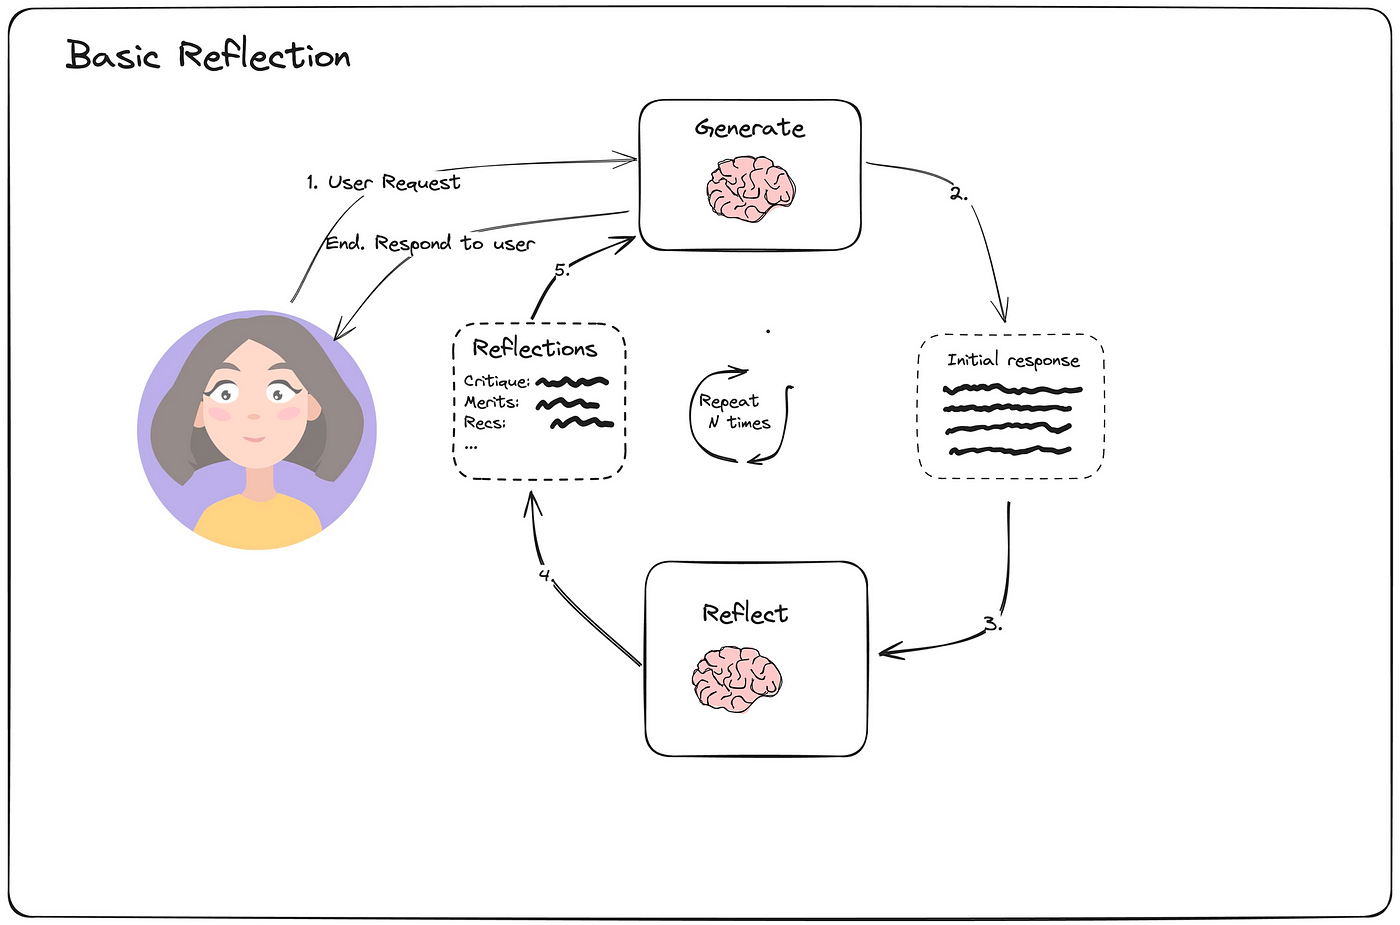

In [42]:
class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        conversation_history: conversation history of two agents - Developer and Tester
    """
    conversation_history: Annotated[list[AnyMessage], operator.add]

In [43]:
# Function used by conditional edge to decide if the tester should continue testing
def should_continue(state):
    if len(state['conversation_history']) > 5:
        print("conversation_history is greater than 3")
        # End after 3 iterations
        return END
    return "tester_node"

In [44]:
builder = StateGraph(GraphState)

builder.add_node("developer_node", developer_node)
builder.add_node("tester_node", tester_node)

builder.set_entry_point("developer_node")

In [45]:
builder.add_conditional_edges("developer_node", should_continue, ['tester_node', END])

builder.add_edge("tester_node", "developer_node")

graph = builder.compile()

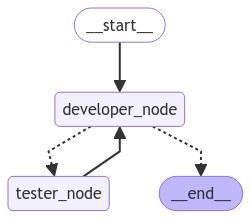

In [46]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

#### Run the graph

In [52]:
import time
from simple_colors import *

def run_reflection(graph, question):
    inputs = {"conversation_history": [HumanMessage(content=question)]}
    start_time = time.time()
    for output in graph.stream(inputs, stream_mode="values"):
        print(blue(output, ['bold']))
    ex_time = time.time() - start_time

    print("--------------------------------------------------------")
    print(red(f"Total Time Taken - [{round(ex_time, 2)}]", ['bold']))
    print("--------------------------------------------------------")

In [53]:
question = "Write a python code for checking if the given string is a palindrome or not"

run_reflection(graph, question)

{'conversation_history': [HumanMessage(content='Write a python code for checking if the given string is a palindrome or not')]}
------ENTERING: DEVELOPER NODE------


ValueError: Can't clean for JSON: HumanMessage(content='Write a python code for checking if the given string is a palindrome or not')